### Import Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import required libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import os

### Define WindowAttention

In [2]:
class WindowAttention(nn.Module):
    def __init__(self, dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5

        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)
        self.attn_map = None

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # each: [B, heads, N, C//heads]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        self.attn_map = attn.detach().cpu()

        out = attn @ v  # [B, heads, N, C//heads]
        out = out.transpose(1, 2).reshape(B, N, C)  # [B, N, C]
        return self.proj(out)

### Swin Block

In [3]:
class SwinBlock(nn.Module):
    def __init__(self, dim, num_heads):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = WindowAttention(dim, num_heads)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

### Mini Swin Transformer

In [4]:
class MiniSwinTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=4, in_chans=3, num_classes=4, embed_dim=96, depth=4, num_heads=3):
        super().__init__()
        self.patch_embed = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        num_patches = (img_size // patch_size) ** 2
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))

        self.blocks = nn.Sequential(
            *[SwinBlock(embed_dim, num_heads) for _ in range(depth)]
        )

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)  # [B, C, H/patch, W/patch]
        x = x.flatten(2).transpose(1, 2)  # [B, N, C]
        x = x + self.pos_embed

        x = self.blocks(x)
        x = self.norm(x)
        x = x.mean(dim=1)
        return self.head(x)

    def get_attention_map(self):
        return self.blocks[-1].attn.attn_map

### Visualization Function

In [5]:
def plot_attention_map(attn_map, token_idx=0):
    attn = attn_map[0].mean(0).numpy()  # [N, N]
    plt.figure(figsize=(6, 5))
    sns.heatmap(attn[token_idx:token_idx+1], cmap="viridis")
    plt.title("Attention Map (Token {})".format(token_idx))
    plt.show()

### Dataset and Dataloader

In [13]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/swindataset.zip'  # เปลี่ยนเป็น path จริง
extract_to = '/content/swindata'             # ตำแหน่งที่จะแตกไฟล์ไป

os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f'✅ แตกไฟล์เรียบร้อยที่: {extract_to}')

✅ แตกไฟล์เรียบร้อยที่: /content/swindata


In [14]:
!rm -rf /content/drive/MyDrive/swindataset/train/.ipynb_checkpoints
!rm -rf /content/drive/MyDrive/swindataset/test/.ipynb_checkpoints

In [18]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms

data_dir = "/content/swindata/swindataset"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = ImageFolder(root=f"{data_dir}/train", transform=transform)
test_dataset = ImageFolder(root=f"{data_dir}/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

print("Classes:", train_dataset.classes)
print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))

Classes: ['COVID', 'LUNG_OPACITY', 'NORMAL', 'VIRAL_PNEUMONIA']
Train samples: 3360
Test samples: 1440


In [ ]:
from collections import Counter

train_class_counts = Counter(train_dataset.targets)
for i, class_name in enumerate(train_dataset.classes):
    print(f"Train - {class_name}: {train_class_counts[i]}")

test_class_counts = Counter(test_dataset.targets)
for i, class_name in enumerate(test_dataset.classes):
    print(f"Test - {class_name}: {test_class_counts[i]}")


Train - COVID: 840
Train - LUNG_OPACITY: 840
Train - NORMAL: 840
Train - VIRAL_PNEUMONIA: 840
Test - COVID: 360
Test - LUNG_OPACITY: 360
Test - NORMAL: 360
Test - VIRAL_PNEUMONIA: 360


### Training

In [14]:
model = MiniSwinTransformer()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [15]:
print(model)

MiniSwinTransformer(
  (patch_embed): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
  (blocks): Sequential(
    (0): SwinBlock(
      (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (attn): WindowAttention(
        (qkv): Linear(in_features=96, out_features=288, bias=True)
        (proj): Linear(in_features=96, out_features=96, bias=True)
      )
      (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=96, out_features=384, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=384, out_features=96, bias=True)
      )
    )
    (1): SwinBlock(
      (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (attn): WindowAttention(
        (qkv): Linear(in_features=96, out_features=288, bias=True)
        (proj): Linear(in_features=96, out_features=96, bias=True)
      )
      (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(

In [ ]:
from tqdm import tqdm

model.train()
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        loop.set_postfix({
            'Loss': loss.item(),
            'Acc': f"{(correct / total) * 100:.2f}%"
        })

    epoch_loss = running_loss / total
    epoch_acc = correct / total * 100
    print(f"✅ Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.2f}%")

✅ Epoch 1/10 - Loss: 1.1538 - Accuracy: 45.18%


✅ Epoch 2/10 - Loss: 0.9661 - Accuracy: 54.43%


✅ Epoch 3/10 - Loss: 0.8885 - Accuracy: 61.31%


✅ Epoch 4/10 - Loss: 0.7845 - Accuracy: 67.08%


✅ Epoch 5/10 - Loss: 0.7278 - Accuracy: 70.12%


✅ Epoch 6/10 - Loss: 0.6820 - Accuracy: 72.44%


✅ Epoch 7/10 - Loss: 0.6201 - Accuracy: 75.36%


✅ Epoch 8/10 - Loss: 0.5861 - Accuracy: 76.99%


✅ Epoch 9/10 - Loss: 0.5355 - Accuracy: 78.48%


✅ Epoch 10/10 - Loss: 0.4949 - Accuracy: 81.01%


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/swinLung.pth")

### Interference and plot Attention

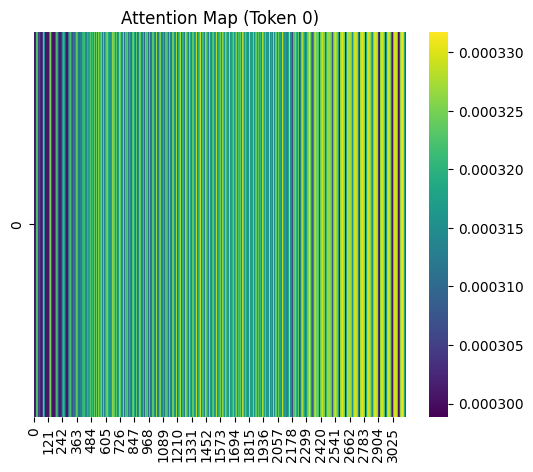

In [ ]:
model.eval()
with torch.no_grad():
    sample_img, _ = next(iter(train_loader))
    sample_img = sample_img.to(device)
    _ = model(sample_img[:1])
    attn_map = model.get_attention_map()
    plot_attention_map(attn_map)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


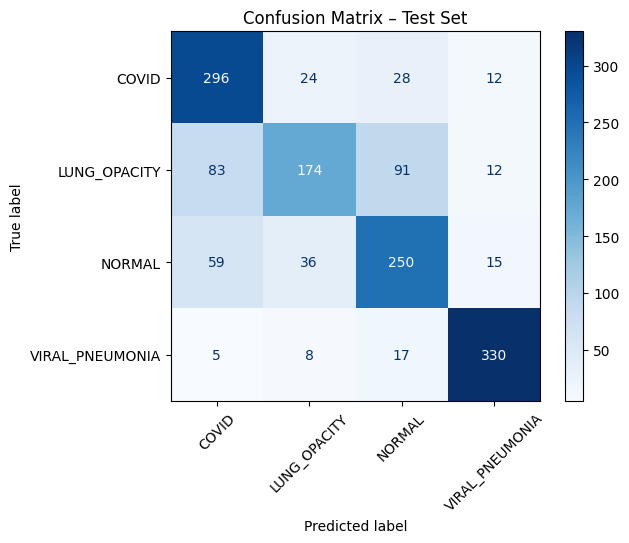

In [ ]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = MiniSwinTransformer(
    img_size=224, patch_size=4, in_chans=3, num_classes=4,
    embed_dim=96, depth=4, num_heads=3
).to(device)


model.load_state_dict(torch.load("/content/drive/MyDrive/swinLung.pth", map_location=device))
model.eval()


all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_loader.dataset.classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix – Test Set")
plt.show()

▶ File: /content/drive/MyDrive/swindataset/train/COVID/COVID-1634.png


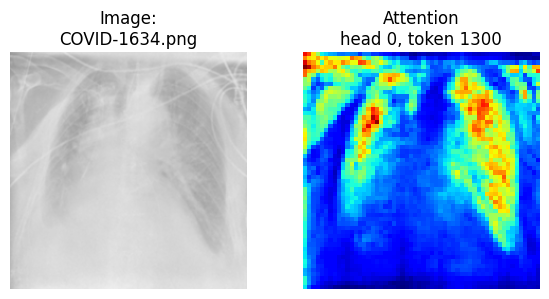

In [ ]:
import torch
import matplotlib.pyplot as plt

# --- 1) เลือก sample ตรง ๆ จาก train_dataset เพื่อรู้ index และ path ----------
idx = 150  # หรือสุ่มก็ได้
img_path, label = train_dataset.samples[idx]   # img_path = พาธไฟล์เต็ม
print("▶ File:", img_path)

# --- 2) โหลดภาพ (ใช้ transform เดิม) ----------------------------------------
sample_img, _ = train_dataset[idx]  # tensor ที่ผ่าน transform แล้ว
sample_img = sample_img.unsqueeze(0).to(device)  # เพิ่ม batch dim

# --- 3) forward เพื่อดึง attention -----------------------------------------
model.eval()
with torch.no_grad():
    _ = model(sample_img)
    attn_map = model.get_attention_map()        # (1, heads, 3136, 3136)

# --- 4) แปลง attention head-0 ของ token-0 เป็น heatmap 56×56 ---------------
head = 0
token = 1300
heat = attn_map[0, head, token].cpu().numpy().reshape(56, 56)

# --- 5) แสดงภาพต้นฉบับ + ชื่อไฟล์ + heatmap -------------------------------
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
# แปลง tensor -> numpy -> [0,1] เพื่อแสดง
img_np = sample_img[0].cpu().numpy().transpose(1,2,0)
img_np = (img_np * 0.5) + 0.5                  # un-normalize
plt.imshow(img_np); plt.axis('off')
plt.title(f"Image:\n{img_path.split('/')[-1]}")   # ชื่อไฟล์อย่างเดียว

plt.subplot(1,2,2)
plt.imshow(heat, cmap='jet'); plt.axis('off')
plt.title(f"Attention\nhead {head}, token {token}")
plt.tight_layout(); plt.show()

Download unlabeldata

In [9]:
import zipfile
import os

# กำหนด path ของไฟล์ zip และโฟลเดอร์ปลายทาง
zip_path = '/content/drive/MyDrive/unlabeldata.zip'           # เปลี่ยนเป็น path ของไฟล์ zip
extract_to = '/content/drive/MyDrive/unlabeldata'      # เปลี่ยนเป็น path ที่ต้องการให้ไฟล์ถูกแตกออก

# สร้างโฟลเดอร์ปลายทางถ้ายังไม่มี
os.makedirs(extract_to, exist_ok=True)

# unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Unziped!")

Unziped!


In [6]:
import os

folder_path = '/content/drive/MyDrive/unlabeldata'

image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.webp')

count = sum(1 for filename in os.listdir(folder_path) if filename.lower().endswith(image_extensions))

print(f"📷 Found {count} images in '{folder_path}'")

📷 Found 1632 images in '/content/drive/MyDrive/unlabeldata'


Preparing Student Model

In [7]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from PIL import Image
import os
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# STEP 1: Load model swinLung
model = MiniSwinTransformer(
    img_size=224, patch_size=4, in_chans=3, num_classes=4,
    embed_dim=96, depth=4, num_heads=3
).to(device)


model.load_state_dict(torch.load("/content/drive/MyDrive/swinLung.pth", map_location=device))
model.eval()

# STEP 2: Prepare image transform (ใช้ transform แบบเดียวกับตอนเทรน)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),                        # Shape: [1, H, W]
    transforms.Lambda(lambda x: x.expand(3, -1, -1)),  # Make it [3, H, W]
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# STEP 3: Load unlabeled dataset
unlabeled_dir = '/content/drive/MyDrive/unlabeldata'
image_paths = [os.path.join(unlabeled_dir, fname) for fname in os.listdir(unlabeled_dir) if fname.endswith('.jpg')]

# STEP 4: Inference & Select high confidence samples
pseudo_images = []
pseudo_labels = []

for path in tqdm(image_paths):
    image = Image.open(path).convert("RGB")
    tensor = transform(image).unsqueeze(0).cuda()

    with torch.no_grad():
        logits = model(tensor)
        probs = F.softmax(logits, dim=1)
        confidence, pred = probs.max(dim=1)

        if confidence.item() > 0.9:
            pseudo_images.append(path)
            pseudo_labels.append(pred.item())

print(f"Selected {len(pseudo_images)} pseudo-labeled images with confidence > 0.9")

100%|██████████| 1632/1632 [11:02<00:00,  2.46it/s]

Selected 139 pseudo-labeled images with confidence > 0.9


In [8]:
# STEP 5: Create new Dataset from selected pseudo-labeled images
class PseudoLabeledDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        image = self.transform(image)
        label = self.labels[idx]
        return image, label

pseudo_dataset = PseudoLabeledDataset(pseudo_images, pseudo_labels, transform)
pseudo_loader = DataLoader(pseudo_dataset, batch_size=8, shuffle=True)

In [9]:
# Freeze feature extractor (everything except 'head')
for name, param in model.named_parameters():
    if not name.startswith("head"):
        param.requires_grad = False

# Optimizer
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()

In [10]:
model.train()
for epoch in range(10):  # 10 more epoch for student
    running_loss = 0
    for inputs, labels in pseudo_loader:
        inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(pseudo_loader)}")

Epoch 1, Loss: 0.08149557974603441
Epoch 2, Loss: 0.07983193629317814
Epoch 3, Loss: 0.07750971015128824
Epoch 4, Loss: 0.07724291727774674
Epoch 5, Loss: 0.0757043489979373
Epoch 6, Loss: 0.07435168781214291
Epoch 7, Loss: 0.0729609698885017
Epoch 8, Loss: 0.07180702148212327
Epoch 9, Loss: 0.07035023346543312
Epoch 10, Loss: 0.06932638378606902


In [11]:
torch.save(model.state_dict(), "/content/drive/MyDrive/swinLungStudentv2.pth")

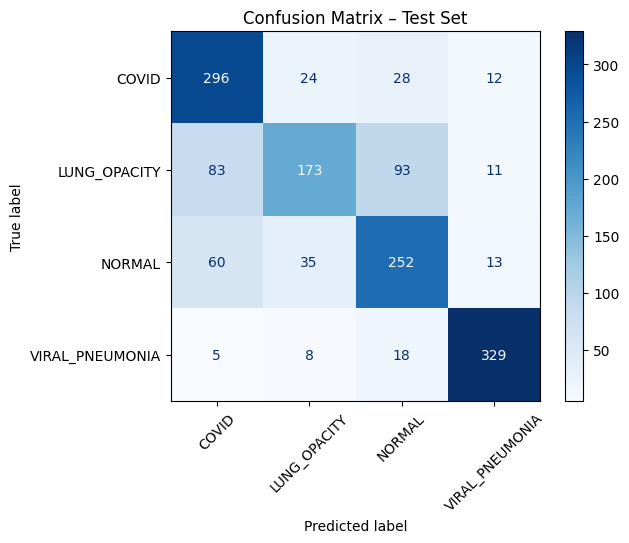

In [19]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = MiniSwinTransformer(
    img_size=224, patch_size=4, in_chans=3, num_classes=4,
    embed_dim=96, depth=4, num_heads=3
).to(device)


model.load_state_dict(torch.load("/content/drive/MyDrive/swinLungStudentv2.pth", map_location=device))
model.eval()


all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_loader.dataset.classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix – Test Set")
plt.show()